# Termination determination

A population is, in theory, always able to increase it fitness with the right set of mutations. However, a termination condition has to be chosen, since we only have a finite time. This notebook attempts to find such a termination condition based on a very long run. The possible termination conditions researched are:
- Termination after the best fitness score has not been increased for N generations.
- Termination after the avg fitness score has not been increased for N generations.
- Termination after the moving average of the best fitnesses with window size of N has not improved.
- Termination after the moving average of the avg fitnesses with window size of N has not improved.

The data was obtained with the following parameters:
```
seed: 1501473247

nruns: 10

population size: 10
selection method: Default

mutate bias method: Default
mutate weight method: Default
mutate probability: 0.15

init bias method: Default
init weight method: Default
activation method: SigmoidScaledSmooth
hidden layer sizes: [4]

Agent details
fov: 60
nrays: 5
max fuel: 5000
```

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from data_visual import DataVisualiser, compute_mean_and_std

In [22]:
# Run cell to increase font sizes. Especially usefull when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (20,10)

In [23]:
data_path = "data/data - termination.txt"

In [24]:
visualiser = DataVisualiser(data_path)

generation_values = visualiser.generation_values
best_values = visualiser.best_values
avg_values = visualiser.avg_values
worst_values = visualiser.worst_values

## Results

### Result: population improvement over time, single run

The figure shows an example of the evolution of a population for a typical run. The best, avg, and worst fitness of the population for each generation are shown. The population does not seem be te be improving after ~500 generations.


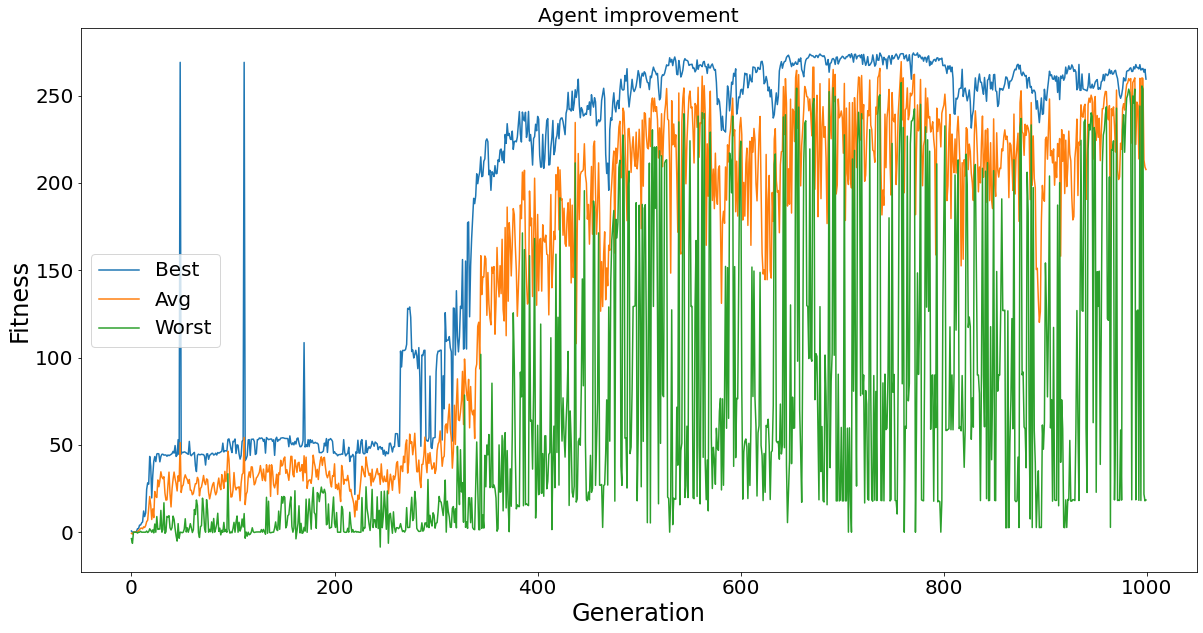

In [25]:
visualiser.plot_a_run(0)

### Results: population improvent over time, multiple runs
Multiple runs need to be performed to get a proper grasp of the system due to the stochasticity of the system. Each line is the result of a single run.

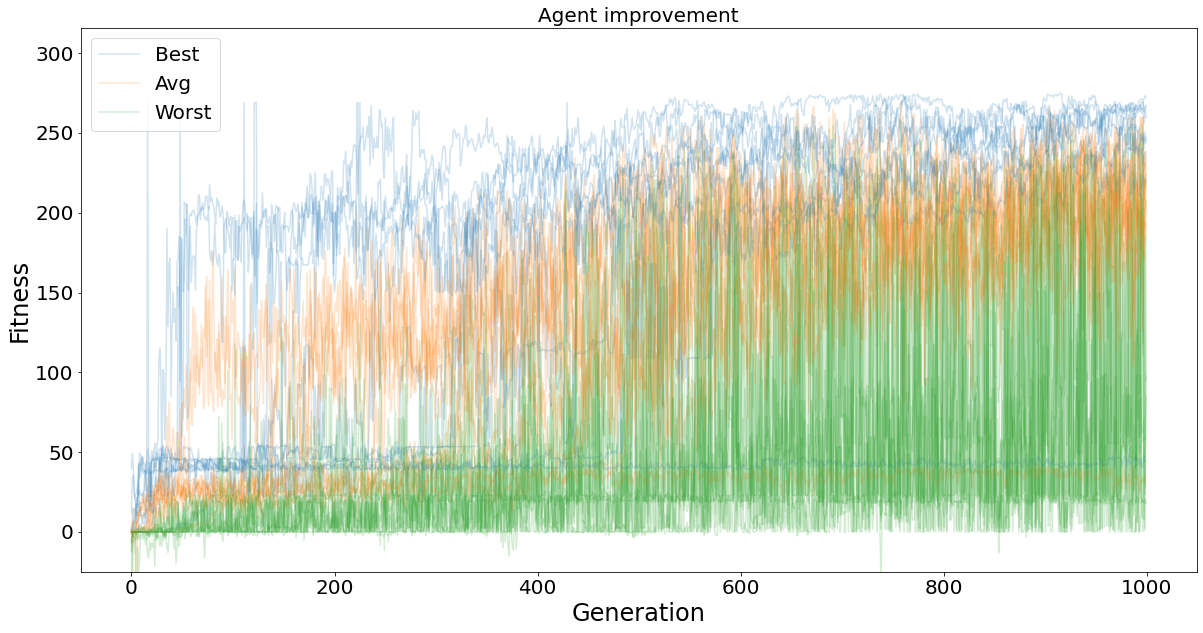

In [26]:
visualiser.plot_all_runs()

The runs are combined into a singular chart, such that we get a mean and standard deviation for each generation.

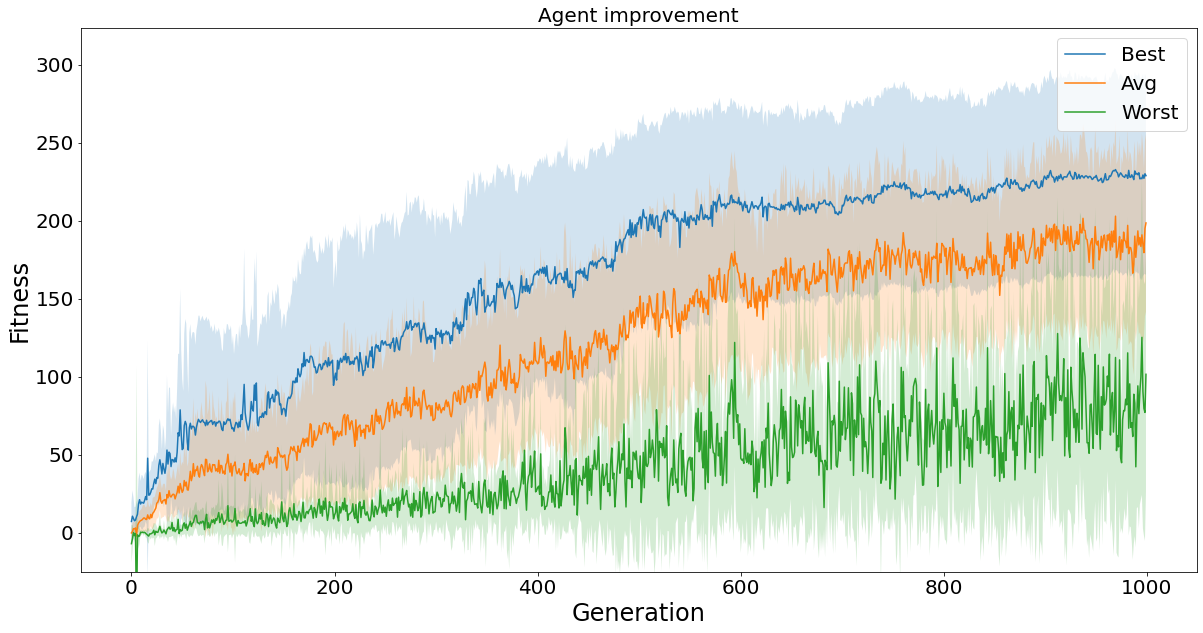

In [27]:
visualiser.plot_combined()

### Result: number of generations since last overall improvement

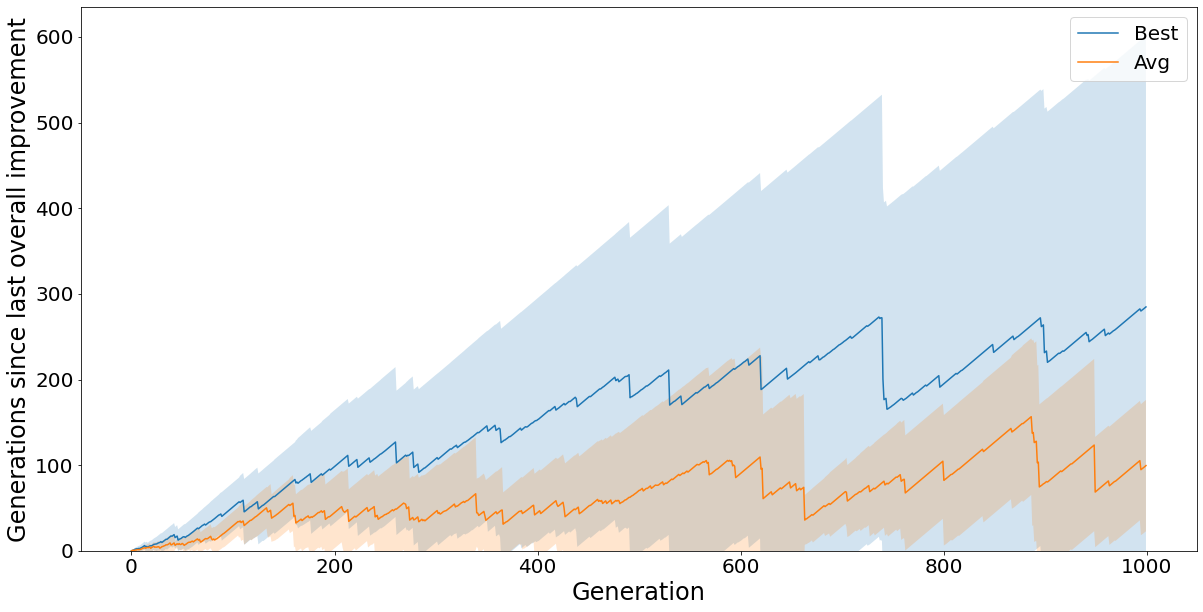

In [28]:
def get_n_values_since_last_improvement(values):

    best = values[0]

    time_since_last_best = 0

    n_values_since_last_improvement = [0]

    for i in range(1, len(values)):

        if values[i] > best:
            time_since_last_best = 0
            best = values[i]
        else:
            time_since_last_best += 1
        
        n_values_since_last_improvement.append(time_since_last_best)

    return n_values_since_last_improvement

time_since_last_best = [get_n_values_since_last_improvement(row) for row in best_values]
time_since_last_best_mean, time_since_last_best_std = compute_mean_and_std(time_since_last_best)

time_since_last_avg = [get_n_values_since_last_improvement(row) for row in avg_values]
time_since_last_avg_mean, time_since_last_avg_std = compute_mean_and_std(time_since_last_avg)

plt.plot(generation_values[0], time_since_last_best_mean, label="Best")
plt.fill_between(generation_values[0], time_since_last_best_mean - time_since_last_best_std, time_since_last_best_mean + time_since_last_best_std, alpha=0.2)

plt.plot(generation_values[0], time_since_last_avg_mean, label="Avg")
plt.fill_between(generation_values[0], time_since_last_avg_mean - time_since_last_avg_std, time_since_last_avg_mean + time_since_last_avg_std, alpha=0.2)

plt.ylim(bottom=0)

plt.xlabel("Generation")
plt.ylabel("Generations since last overall improvement")

plt.legend()
plt.show()

The figure shows the number of generations since an overall improvement is observed. This is done both for the average fitness of the population as well as for the best indiviudal of each generation. It can be seen that as more generations have occured, more generations are needed before a new improvement can be found. This is of course as expected.

### Result: Fitness value with N steps since last improvement

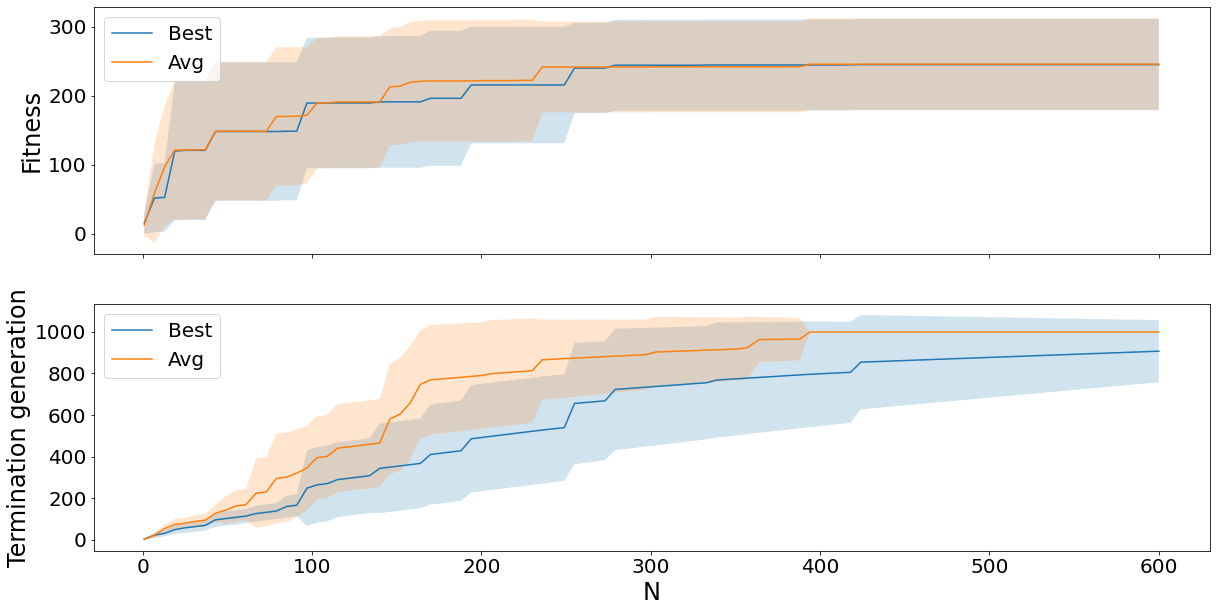

In [29]:
def get_fitness_score(nested_list, N, termination_function):
    
    termination_indices = [termination_function(row, N) for row in nested_list]

    fitness_values = [max(best_values[i][:termination_indices[i] + 1]) for i in range(len(termination_indices))]
    
    fitness_means, fitness_stds = compute_mean_and_std(fitness_values)
    termination_means, termination_stds = compute_mean_and_std(termination_indices)
    
    return fitness_means, fitness_stds, termination_means, termination_stds


def get_termination_index(row, N):
    
    for i in range(N, len(row)):

        # Current implementation not at all efficient, but it works
        # Should cache these instead of recalculating np.argmax everytime
        max_index = np.argmax(row[:i])
        if i > max_index + N:
            break

    return i

def get_data(Ns, nested_list, termination_function):

    fitness_means = np.zeros(len(Ns))
    fitness_stds = np.zeros(len(Ns))
    termination_means = np.zeros(len(Ns))
    termination_stds = np.zeros(len(Ns))

    for i, N in enumerate(Ns):

        fitness_mean, fitness_std, termination_mean, termination_std = get_fitness_score(nested_list, N, termination_function)
        fitness_means[i] = fitness_mean
        fitness_stds[i] = fitness_std
        termination_means[i] = termination_mean
        termination_stds[i] = termination_std

    return fitness_means, fitness_stds, termination_means, termination_stds

def plot_data(Ns, termination_function):

    best_values_means, best_values_stds, termination_best_means, termination_best_stds = get_data(Ns, best_values, termination_function)
    avg_values_means, avg_values_stds, termination_avg_means, termination_avg_stds = get_data(Ns, avg_values, termination_function)

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(Ns, best_values_means, label="Best")
    ax1.fill_between(Ns, best_values_means - best_values_stds, best_values_means + best_values_stds, alpha=0.2)

    ax1.plot(Ns, avg_values_means, label="Avg")
    ax1.fill_between(Ns, avg_values_means - avg_values_stds, avg_values_means + avg_values_stds, alpha=0.2)

    ax1.legend()
    ax1.set_ylabel("Fitness")

    ax2.plot(Ns, termination_best_means, label="Best")
    ax2.fill_between(Ns, termination_best_means - termination_best_stds, termination_best_means + termination_best_stds, alpha=0.2)

    ax2.plot(Ns, termination_avg_means, label="Avg")
    ax2.fill_between(Ns, termination_avg_means - termination_avg_stds, termination_avg_means + termination_avg_stds, alpha=0.2)
    ax2.legend()
    ax2.set_xlabel("N")
    ax2.set_ylabel("Termination generation")

    plt.show()

Ns = np.linspace(1, 600, 100, dtype=int)
plot_data(Ns, get_termination_index)


The figure shows the maximum obtained fitness score when the population has not been able to improve their score for N generations. The fitness score improves stepwise until N ~ 250.  No preference for the best or average fitness score is noted, however it takes quite a bit more generations when applied to the average fitness. Therefore, applying this method for the best case would result in faster termination, while maintaining the same fitness score.

### Result: Fitness value when the moving average over the last N points should always be increasing

NOTE: this is the same as checkig if the fitness at index i + N is greater than the fitness at index i


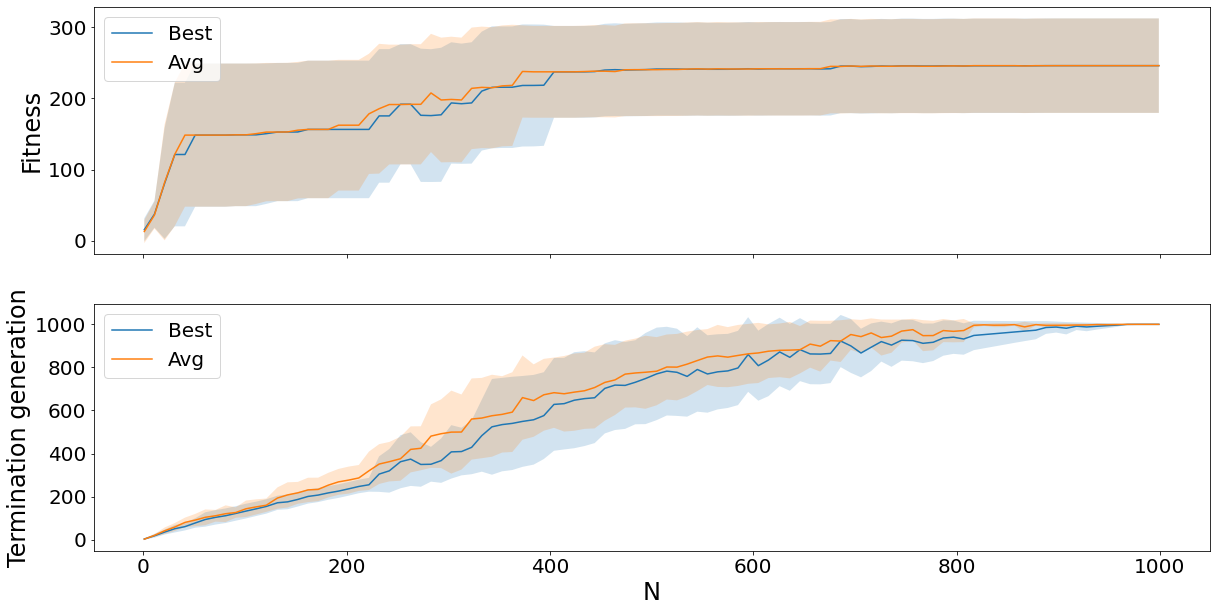

In [30]:
def get_termination_index(row, N):
    
    for i in range(N, len(row)):

        if row[i] < row[i - N]:
            break

    return i

Ns = np.linspace(1, 999, 100, dtype=int)
plot_data(Ns, get_termination_index)

The figure shows how the maximum obtained fitness values change depending on different N values. There appears to be no distinct difference when this is applied to both the best and average of a generation. The sudden jump of fitness occurs at N ~ 50. At this point it seems that the population has reached a good solution and that only after a bunch of mutations it is able to find improvements.

## Conclusion

The method "N steps since last improvement" did not have a clear point at which the fitness score does not depend on N. The opposite was true for the moving average method. At N ~ 50 the fitness score does not improve much more. Relatively few generations have also occured at this point making it ideal to reduce the computational cost. The avg case is chosen, since it should be less impacted by outliers, eventhough the data showed no difference between the avg and best case.